In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import pickle
import pandas as pd

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (15,10)
plt.style.use('seaborn')

In [2]:
# open the file of interest, and use pickle loading
infile = open ("qcd_100000_pt_1000_1200.pkl",'rb')
background_dict = pickle.load(infile)

# open the file of interest, and use pickle loading
infile = open ("higgs_100000_pt_1000_1200.pkl",'rb')
signal_dict = pickle.load(infile)

# list all keys of the files
keys = background_dict.keys()
keys

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [3]:
d = {keys[0] : background_dict[keys[0]]}
for i in range(len(keys)):
    d[keys[i]] = background_dict[keys[i]]

df = pd.DataFrame(data=d)
df

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
0,1034.181543,1.193191,2.942234,272.010881,0.102485,0.003492,3.244343,0.006256,0.961697,0.598986,0.425024,0.622843,0.709573,0.082995
1,1125.535509,-1.833090,0.121390,139.794408,0.035430,0.000288,6.481473,0.000155,0.896003,0.633385,0.476566,0.706900,0.752412,0.439346
2,1099.223087,0.557867,-1.238027,245.413146,0.099080,0.002563,2.634788,0.005682,0.861678,0.486505,0.264631,0.564602,0.543942,0.251453
3,1118.230032,1.505473,1.953123,89.975916,0.017950,0.000077,13.389845,0.000432,0.952917,0.856141,0.730438,0.898442,0.853175,0.121666
4,1059.907996,-0.387179,-1.064832,85.893956,0.018515,0.000072,11.342156,0.002575,0.868770,0.645362,0.484853,0.742845,0.751289,0.386788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1185.924965,-1.282700,-2.203558,178.917178,0.051779,0.000606,4.368135,0.000900,0.671057,0.294523,0.255893,0.438894,0.868838,0.282015
99996,1070.385446,-0.762397,-2.405166,143.872351,0.032136,0.000224,6.749812,0.002829,0.718651,0.293553,0.268076,0.408478,0.913209,0.261662
99997,1116.722590,-0.166511,-1.141038,118.185074,0.049617,0.000331,2.712970,0.002456,0.859900,0.642900,0.456476,0.747645,0.710027,0.147913
99998,1147.609045,0.405501,-1.125710,292.925318,0.129771,0.004310,1.972101,0.005786,0.930685,0.672938,0.361115,0.723057,0.536624,0.567817


All the variables and (a few of) their values are shown in the table above. This is completely unhelpful for analysis but gives a rough idea of what to expect.

### Terminology: 
- pt: Transverse momentum
- eta: Pseudorapidity
- phi: Azimuthal angle
- mass
- ee2: energy correlation function
- ee3: energy correlation function
- d2: energy correlation function
- angularity
- t1: subjettiness with one particle
- t2: subjettiness with 2 particles
- t3: subjettiness with 3 particles
- t21: t2 / t1
- t32: t3 / t2
- KtDeltaR: Delta R of 2 subjets within the large R jet

**Do all of the features provide discrimination power between signal and background?**

Qualitatively yes, as seen by the plots below. Phi does not, as expected (ranges from $-\pi$ to $\pi$ for both) and t32 has significant overlap between signal and background.

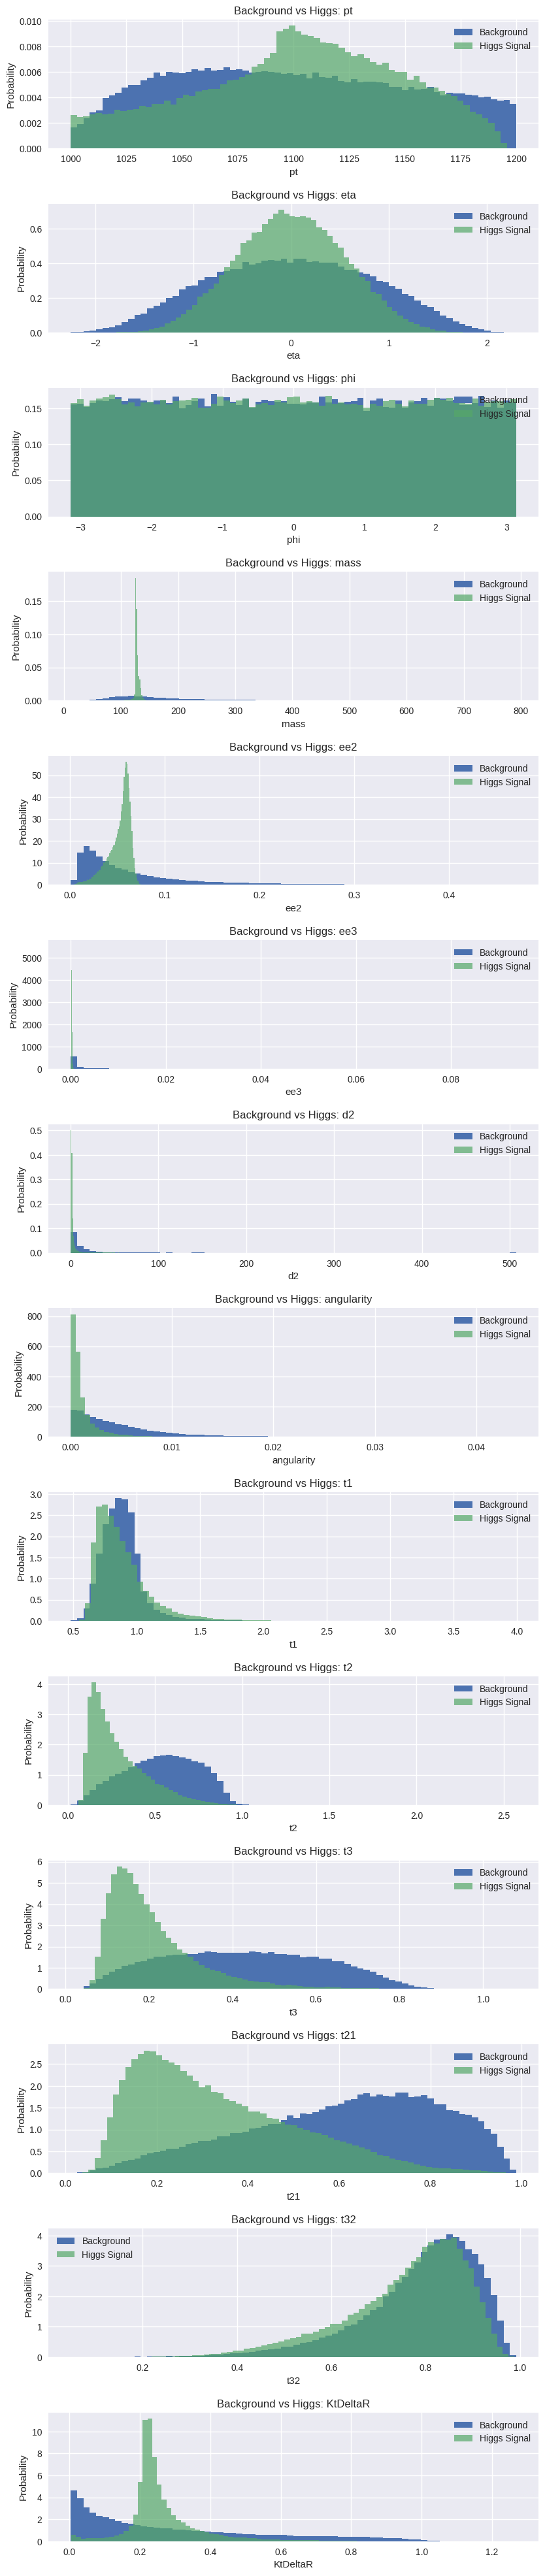

In [10]:
fig, ax = plt.subplots(len(keys), 1, figsize=(9,40))
fig.tight_layout(pad=4)

for i in range(len(keys)):
    ax[i].hist(background_dict[keys[i]], bins=70, density=True, label="Background")
    ax[i].set_xlabel(str(keys[i]))
    ax[i].set_ylabel("Probability")
    ax[i].set_title("Background vs Higgs: "+str(keys[i]))
    
    ax[i].hist(signal_dict[keys[i]], bins=70, density=True, label="Higgs Signal", alpha=0.7)
    
    ax[i].legend(loc=0)
    
# ax[0,0].set_title("Background", fontsize=20)
# ax[0,1].set_title("Higgs Signal", fontsize=20)

plt.show()

**Are there correlations among these features?**

We can calculate how much one variable depends on another with the correlation coefficient:

$r =\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$, 
where $\bar{x}$ and $\bar{y}$ are the means of the respective data sets.

A correlation of -1.0 shows a perfect negative correlation and a correlation of 1.0 shows a perfect positive correlation.

In [14]:
def correlation_coeff(x, x_bar, y, y_bar):
    x_diff = x - x_bar
    y_diff = y - y_bar
    num = np.sum((x_diff)*(y_diff))
    den = np.sqrt(np.sum((x_diff)**2)*np.sum((y_diff)**2))
    r = num / den
    return r

In [15]:
correleation_array = np.zeros([len(keys), len(keys)])
for i in range(len(keys)):
    for j in range(len(keys)):
        r = correlation_coeff(background_dict[keys[i]].values, np.mean(background_dict[keys[i]]), 
                              background_dict[keys[j]].values, np.mean(background_dict[keys[j]]))
        correleation_array[i,j] = r

Sanity checks: are any values over 1.0 or under -1.0?

In [16]:
print(correleation_array.max())
print(correleation_array.min())

1.0
-0.6397338087163849


All are within the range. The correlation of a variable with every other variable can be seen in the table below. 

Note -- this is just calculated for the background.

In [17]:
d = {keys[0] : " "}

for i in range(len(keys)):
    
    d[keys[i]] = correleation_array[i]

df = pd.DataFrame(data=d, index=[keys])
df

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
pt,1.000000,0.000083,-0.006469,0.095461,0.012772,0.006981,-0.003817,0.032309,-0.010783,-0.027798,-0.033102,-0.027596,-0.024690,0.024390
eta,0.000083,1.000000,0.001784,0.000767,0.000499,0.001447,-0.002371,0.000908,-0.002803,-0.001568,-0.001840,-0.000351,-0.000405,-0.002086
phi,-0.006469,0.001784,1.000000,-0.005159,-0.003282,-0.003464,0.001273,-0.008891,0.002601,0.000465,0.001326,-0.000321,0.002848,-0.003087
mass,0.095461,0.000767,-0.005159,1.000000,0.959965,0.793991,-0.538750,0.529638,0.010450,-0.533355,-0.621826,-0.585519,-0.459640,0.708356
ee2,0.012772,0.000499,-0.003282,0.959965,1.000000,0.844699,-0.567445,0.427854,0.126657,-0.517926,-0.620038,-0.613574,-0.495083,0.614471
ee3,0.006981,0.001447,-0.003464,0.793991,0.844699,1.000000,-0.306321,0.433308,0.138780,-0.250764,-0.350501,-0.323984,-0.412092,0.459877
d2,-0.003817,-0.002371,0.001273,-0.538750,-0.567445,-0.306321,1.000000,-0.184381,-0.022127,0.554533,0.622112,0.619491,0.325022,-0.392433
angularity,0.032309,0.000908,-0.008891,0.529638,0.427854,0.433308,-0.184381,1.000000,-0.052497,-0.152266,-0.196199,-0.155062,-0.190053,0.406357
t1,-0.010783,-0.002803,0.002601,0.010450,0.126657,0.138780,-0.022127,-0.052497,1.000000,0.326725,0.238284,-0.002957,-0.146209,-0.271773
t2,-0.027798,-0.001568,0.000465,-0.533355,-0.517926,-0.250764,0.554533,-0.152266,0.326725,1.000000,0.936640,0.926364,0.129887,-0.635300


Now we can check the largest correleations for each variable, not counting the correlation with itself.

In [22]:
max_correlation = []
index = []

for i in range(len(keys)):
    x = np.sort(correleation_array[i])
    max_val = x[-2]
    if(abs(x[0]) > max_val):
        max_val = x[0]
    max_correlation = np.append(max_correlation, max_val)
    index = np.append(index, keys[np.where(correleation_array[i]==max_val)])
    
    
for i in range(len(keys)):    
    print(str(keys[i])+": "+str(round(max_correlation[i],4))+", "+str(index[i]))

pt: 0.0955, mass
eta: -0.0028, t1
phi: -0.0089, angularity
mass: 0.96, ee2
ee2: 0.96, mass
ee3: 0.8447, ee2
d2: 0.6221, t3
angularity: 0.5296, mass
t1: 0.3267, t2
t2: 0.9366, t3
t3: 0.9366, t2
t21: 0.9264, t2
t32: -0.4951, ee2
KtDeltaR: 0.7084, mass


Finally, we can visualise the data by making 2D histograms of the variables with the highest correlations.

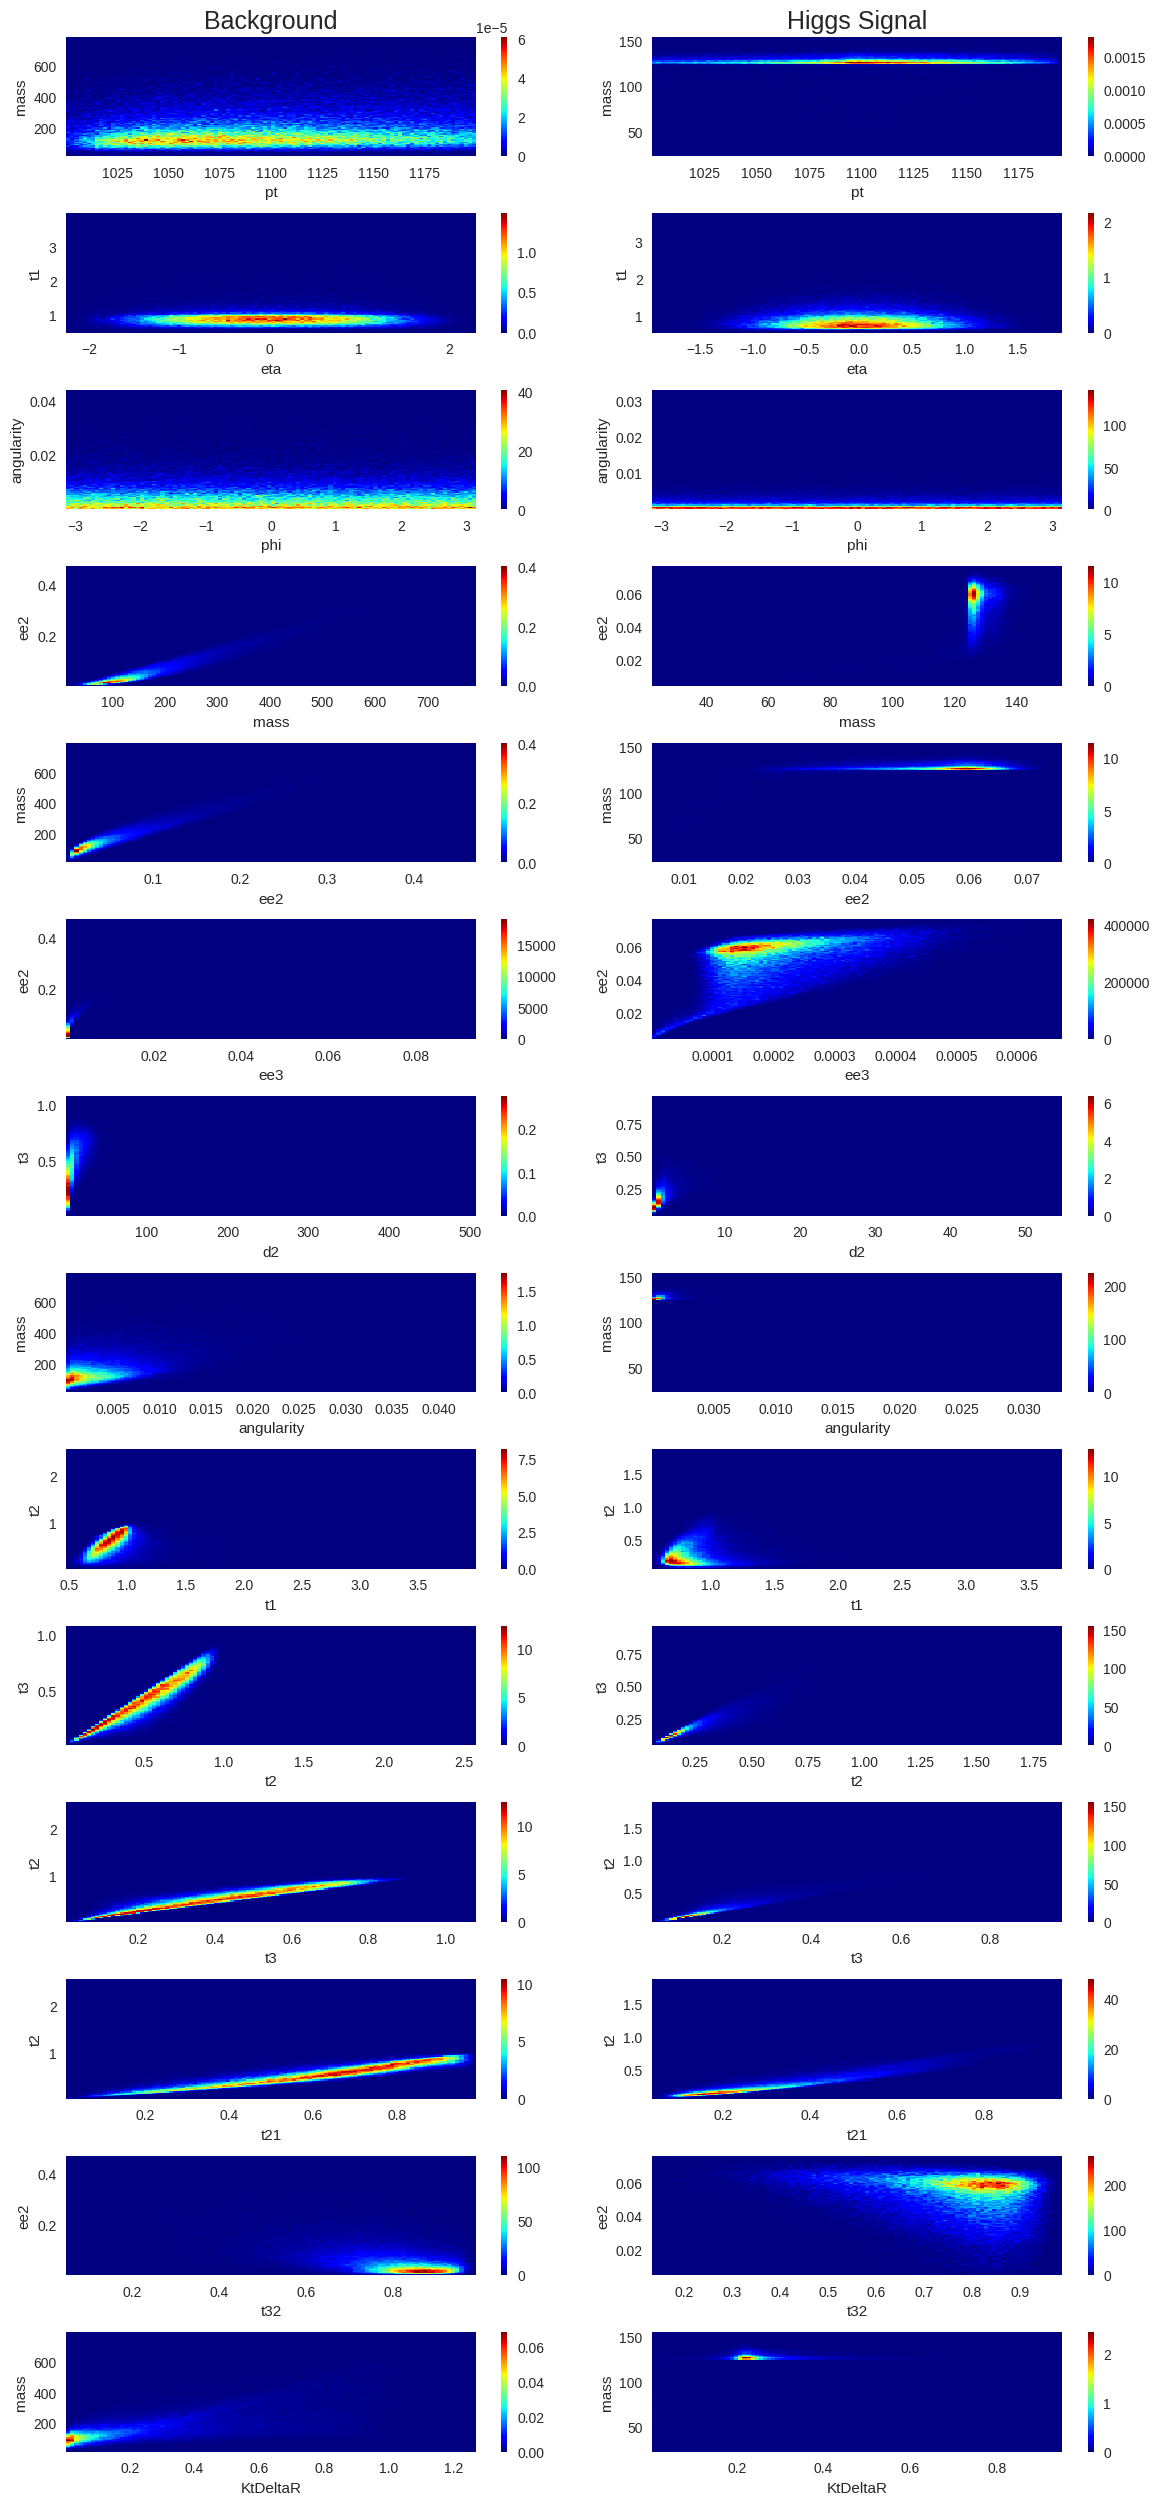

In [23]:
fig, ax = plt.subplots(int(len(keys)), 2, figsize=(12, 25))
fig.tight_layout(pad=2)

for i in range(int(len(keys))):
    a = ax[i,0].hist2d(background_dict[keys[i]], background_dict[index[i]], bins=(100, 100), cmap=plt.cm.jet, density=True)
    plt.colorbar(a[3], ax=ax[i,0])
    ax[i,0].set_xlabel(str(keys[i]))
    ax[i,0].set_ylabel(str(index[i]))

    b = ax[i,1].hist2d(signal_dict[keys[i]], signal_dict[index[i]], bins=(100, 100), cmap=plt.cm.jet, density=True)
    plt.colorbar(b[3], ax=ax[i,1])
    ax[i,1].set_xlabel(str(keys[i]))
    ax[i,1].set_ylabel(str(index[i]))

ax[0,0].set_title("Background", fontsize=18)
ax[0,1].set_title("Higgs Signal", fontsize=18)

plt.show()

**Compute the expected discovery sensitivity (significance of the expected signal) by normalizing each sample appropriately.**

Can make a histogram plot for the feature variable (mass). For this sample, $N_{higgs} = 50$ and $N_{qcd} = 2000$.

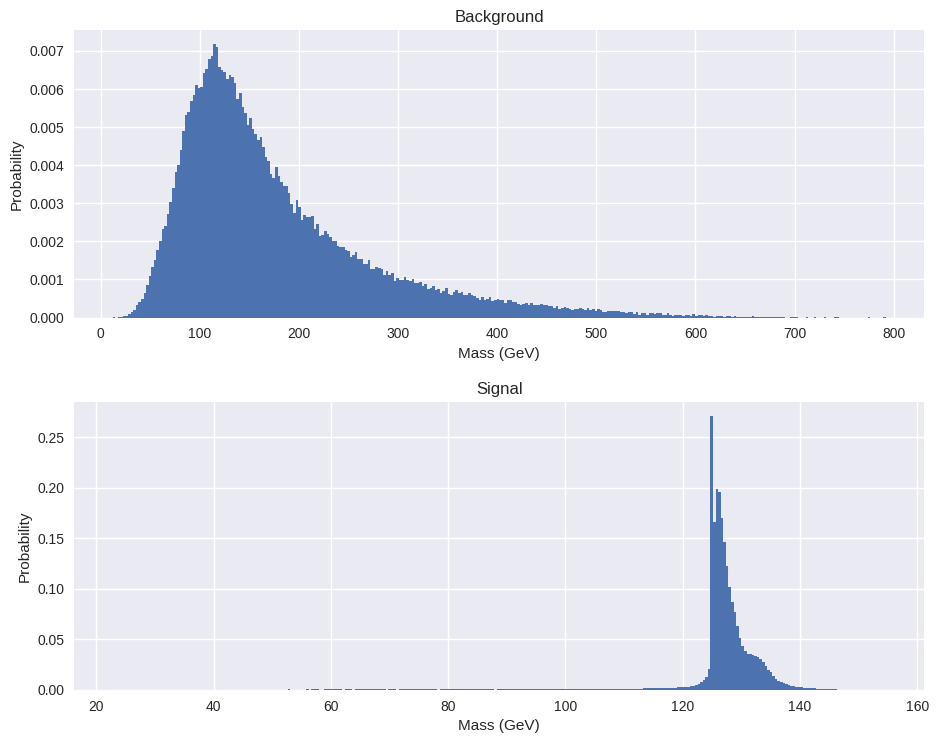

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plt.tight_layout(pad=4)

ax[0].hist(background_dict['mass'], bins=300, density=True)
ax[0].set_xlabel("Mass (GeV)")
ax[0].set_ylabel("Probability")
ax[0].set_title("Background")

ax[1].hist(signal_dict['mass'], bins=300, density=True)
ax[1].set_xlabel("Mass (GeV)")
ax[1].set_ylabel("Probability")
ax[1].set_title("Signal")

plt.show()

To find the significance of a Higgs discovery, we can normalize the data and integrate from the mean of the signal (126.6 GeV) to infinity. 

In [63]:
bkgd_mass = background_dict['mass']
sorted_bkgd = np.sort(bkgd_mass)
norm_bkgd = sorted_bkgd / np.sum(sorted_bkgd)

higgs_mean = np.mean(higgs_mass)

In [92]:
for i in range(len(sorted_bkgd)):
    if sorted_bkgd[i] >= higgs_mean:
        index = i
        break
        
prob = np.sum(norm_bkgd[index:-1])

In [93]:
sigma = stats.norm.ppf(prob, loc=0, scale=1)

print("The significance of a "+str(round(higgs_mean, 2))+" GeV signal is "+str(abs(round(sigma,2)))+" sigma.")

The significance of a 126.66 GeV signal is 0.84 sigma.


In [100]:
prob5sigma = stats.norm.cdf(5, loc = 0, scale = 1)

for i in range(100):
    prob_pwr = prob**i
    if prob_pwr < (1-prob5sigma):
        print("You would need "+str(i)+" independent readings of the Higgs mass to get 5 sigma significance")
        break

You would need 68 independent readings of the Higgs mass to get 5 sigma significance


In [111]:
bgkd_prob = []
for i in range(len(norm_bkgd)):
    bgkd_prob = np.append(bgkd_prob, norm_bkgd[i])
    if np.sum(bgkd_prob) >= prob5sigma:
        print("You would need a mass reading of "+str(round(sorted_bkgd[i],2))+" for 5 sigma significance")
        break

You would need a mass reading of 791.96 for 5 sigma significance


To optimize the sensitivity, we can look at what features have high correlations and if they would impact the mass. We can look for segments of mass with lower background, for example, which would require a lower signal to reach significance. We could also throw out data that has a large background where we don't expect to see any signal.

### For Fun:

Plot each variable against each other variable as a 2D histogram. Left: background. Right: higgs.

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(182, 2, figsize=(25, 600))
fig.tight_layout(pad=1)

i = 0 
for key in background_dict:
    for key2 in background_dict:
        if key != key2:
            a = ax[i,0].hist2d(background_dict[key], background_dict[key2], bins=(100, 100), cmap=plt.cm.jet, density=True)
            plt.colorbar(a[3], ax=ax[i,0])
            ax[i,0].set_xlabel(key)
            ax[i,0].set_ylabel(key2)
            
            a = ax[i,1].hist2d(signal_dict[key], signal_dict[key2], bins=(100, 100), cmap=plt.cm.jet, density=True)
            plt.colorbar(a[3], ax=ax[i,1])
            ax[i,1].set_xlabel(key)
            ax[i,1].set_ylabel(key2)
            i = i+1

plt.show()